In [2]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array

import sys
sys.path.append('../..')
import snowFun

In [1]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "01_rgi60_Alaska", "01_rgi60_Alaska.shp")
rgi_gdf = gpd.read_file(path_rgi).to_crs("EPSG:3338")

# open o3 region shapefile
path_o3 = os.path.join(folder_AGVA, 'RGI', "O3Regions", "O3Regions.shp")
o3_gdf = gpd.read_file(path_o3).to_crs("EPSG:3338")

In [2]:
# subset to glaciers not in brooks range, greater than 2km
rgi_gdf = rgi_gdf[rgi_gdf['Area']>=2]
rgi_gdf = rgi_gdf[rgi_gdf['O2Region']!="1"]

<Axes: >

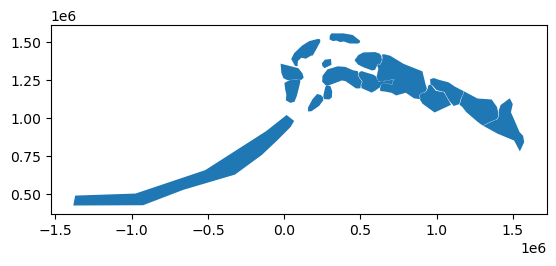

In [3]:
o3_gdf.plot()

In [4]:
def get_S2_subregion(rgi_geom):
    
    # find the subregion that intersects the rgi_geom
    all_correct_subregion = o3_gdf[o3_gdf['geometry'].contains(rgi_geom.values[0])]#['id'].values[0]
    
    ### handling the cases of the overlapping rgi subregions
    # if no overlap, then just return the single correct subregion
    if len(all_correct_subregion)==1:
        to_return = ( all_correct_subregion['id'].values[0], all_correct_subregion['Name'].values[0] )
    
    # else, contain the one whose intersection is largest
    else:
        
        # find the subregions that intersect
        intersections = o3_gdf.intersects(rgi_geom.values[0])
        
        # if none intersect, return nulls
        if np.nansum(intersections)==0:
            to_return = ( 0, "NONE")
        
        # else, find which has the largest intersection
        else:
            
            possible = o3_gdf[intersections]
            area1 = possible.geometry.iloc[0].intersection(rgi_geom.values[0]).area
            area2 = possible.geometry.iloc[1].intersection(rgi_geom.values[0]).area
            
            if area1>area2:
                to_return = (possible.iloc[0]['id'], possible.iloc[0]['Name'])
            else:
                to_return = (possible.iloc[1]['id'], possible.iloc[1]['Name'])
                
    return to_return

In [5]:
c=0
all_rgis = [i for i in rgi_gdf['RGIId']]
o3s = []
names = []

for i in all_rgis:

    row = rgi_gdf[rgi_gdf['RGIId']==i]
    test = get_S2_subregion(row.geometry)
    o3s.append(test[0])
    names.append(test[1])
    c+=1
    
rgi_gdf['O3Region'] = o3s
rgi_gdf['O3_name'] = names

In [6]:
out_path = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf.to_file(out_path)